In [1]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import numpy as np
import pandas as pd
import pickle
import networkx as nx
import matplotlib.pyplot as plt
from itertools import chain, combinations, product
from sklearn.model_selection import cross_val_predict
from networkx.algorithms.components import connected_components as connected_components
from nilearn.plotting import plot_connectome

In [3]:
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPool1D, Dropout, Flatten
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
def edgelist_to_nx(edgelists):
    motifs = []
    for edgelist in edgelists:
        tmp = nx.empty_graph()
        for (n1,n2) in edgelist:
            tmp.add_edge(n1,n2)
        motifs.append(tmp)
    return motifs

In [5]:
def make_brain_dataset():
    td = pickle.load(open(DATA_FOLDER+EXP_NAME+'_td','rb'))
    asd = pickle.load(open(DATA_FOLDER+EXP_NAME+'_asd','rb'))
    graphs = td+asd
    labels = np.array([0.]*len(td)+[1.]*len(asd))
    idxs = np.arange(len(graphs))
    np.random.shuffle(idxs)
    max_train = int(len(graphs)*.75)
    idxs_trn = idxs[:max_train]
    idxs_tst = idxs[max_train:]
    xgraph_trn = [graphs[i] for i in idxs_trn]
    xgraph_tst = [graphs[i] for i in idxs_tst]
    label_trn = labels[idxs_trn].astype(int)
    label_tst = labels[idxs_tst].astype(int)
    return xgraph_trn,xgraph_tst,label_trn,label_tst

In [6]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))

def pascaline(n):
    "pascaline(5) -> [1, 4, 6, 4, 1]"
    n -= 1
    line = [1]
    for k in range(max(n,0)):             
        line.append(line[k]*(n-k)//(k+1))             
    return line

def get_marginal(lattice,binary_code,position):
    key_nope = tuple((*binary_code[:position],0,*binary_code[position:]))
    key_with = tuple((*binary_code[:position],1,*binary_code[position:]))
    return lattice[key_nope]-lattice[key_with]

In [7]:
def normalise_adjm(adjm):
    adjm = np.array(adjm)
    n_batch, n_row, n_col = adjm.shape
    adjm = tf.add(np.eye(n_row).astype(np.float32),adjm)
    weights_row = tf.tensordot(adjm,tf.ones(n_col),axes=1)
    weights_col = tf.tensordot(tf.transpose(adjm,perm=[0,2,1]),tf.ones(n_row),axes=1)
    diag_row = tf.math.divide_no_nan(1.,tf.pow(weights_row, 0.5))
    diag_col = tf.math.divide_no_nan(1.,tf.pow(weights_col, 0.5))
    tmp = tf.multiply(adjm,tf.expand_dims(diag_col,axis=1))
    Anorm = tf.multiply(tf.expand_dims(diag_row,axis=2),tmp)
    return Anorm

class GConvNodeID(tf.keras.layers.Layer):
    def __init__(self,num_feat,num_out,activation):#W has shape (nodes,1)
        super(GConvNodeID,self).__init__()
        self.W = tf.Variable(tf.keras.initializers.GlorotUniform(seed=None)(shape=(num_feat,num_out)))
        self.activation = activation
    def call(self,A,X):
        XW = tf.einsum('bij,jk->bik',X,self.W)
        AXW = tf.einsum('bij,bjk->bik',A,XW)
        return self.activation(AXW)

In [8]:
def param_get_gconvnet(nodes_per_graph,dr1=.45,dr2=.45,num_neurons=32,activ='tanh',lr=.0001,loss='mse'):
    attr_input = tf.keras.Input(shape=(nodes_per_graph,nodes_per_graph))
    adjm_input = tf.keras.Input(shape=(nodes_per_graph,nodes_per_graph))
    activ = tf.nn.relu if activ=='relu' else tf.nn.tanh if activ=='tanh' else None
    #
    drop1 = tf.keras.layers.Dropout(dr1)(attr_input)
    gc1 = GConvNodeID(nodes_per_graph,num_neurons, activation=activ)(adjm_input,drop1)
    drop2 = tf.keras.layers.Dropout(dr1)(gc1)
    gc2 = GConvNodeID(num_neurons,num_neurons, activation=activ)(adjm_input,drop2)
    drop3 = tf.keras.layers.Dropout(dr1)(gc2)
    gc3 = GConvNodeID(num_neurons,num_neurons, activation=activ)(adjm_input,drop3)
    conc = tf.concat([gc1,gc2,gc3], axis=-1)
    conv1d =  tf.keras.layers.Conv1D(filters=num_neurons, kernel_size=5, strides=1)(conc)
    flat = tf.keras.layers.Flatten()(conv1d)
    dense1 = tf.keras.layers.Dense(units=128, activation=activ)(flat)#was relu
    dropf = tf.keras.layers.Dropout(dr2)(dense1)
    dense2 = tf.keras.layers.Dense(units=1, activation=tf.nn.sigmoid)(dropf)
    #
    gcnv = tf.keras.Model(inputs=[attr_input,adjm_input], outputs=dense2)
    gcnv.compile(optimizer=Adam(lr=lr), loss=loss)
    #
    return gcnv

In [9]:
def occurs_adjm(graph_adjm,edge_motif):
    return int((np.array([graph_adjm[x,y] for (x,y) in edge_motif])).all())

def mask_binary_toggle_edgelist(graph_adjm,edge_motifs,motifs_to_mask,occurring):
    adjm_clone = np.copy(graph_adjm)
    to_remove = [(em,tm,oc) for (em,tm,oc) in zip(edge_motifs,motifs_to_mask,occurring) if tm==1 and oc==1]
    for (edgex,edgey) in [a for b in [x[0] for x in to_remove] for a in b]:
        adjm_clone[edgex,edgey] = 0
        adjm_clone[edgey,edgex] = 0
    to_add = [(em,tm,oc) for (em,tm,oc) in zip(edge_motifs,motifs_to_mask,occurring) if tm==1 and oc==0]
    for (edgex,edgey) in [a for b in [x[0] for x in to_add] for a in b]:
        adjm_clone[edgex,edgey] = 1
        adjm_clone[edgey,edgex] = 1
    return adjm_clone

In [10]:
def get_batch_lattice(model,dummy_attr,graph_dataset,motifs):
    edge_motifs = [list(m.edges) for m in motifs]
    occurring = [[occurs_adjm(g,em) for em in edge_motifs] for g in graph_dataset]
    lattice_nodes = {}
    for motifs_to_mask in product([0, 1], repeat=len(motifs)):#FIX - minus one??
        masked_adjms = [mask_binary_toggle_edgelist(g,edge_motifs,motifs_to_mask,occ) \
                        for g,occ in zip(graph_dataset,occurring)]
        masked_datapoints = normalise_adjm(np.array(masked_adjms))
        scores = model.predict([dummy_attr,np.array(masked_datapoints)]).T[0]
        lattice_nodes[motifs_to_mask] = scores
    return lattice_nodes

def get_batch_shaps(lattice):
    num_motifs = len(list(lattice.keys())[0])
    num_graphs = len(list(lattice.values())[0])
    pascal = pascaline(num_motifs)
    edge_iterator = list(product([0, 1], repeat=num_motifs-1))
    num_edges = len(edge_iterator)
    depths = [min(sum(x),num_motifs-1-sum(x)) for x in edge_iterator]
    coef = [1./num_motifs/pascal[sum(code)] for code in edge_iterator]
    shap_tensor = np.zeros((num_edges,num_motifs,num_graphs))
    for motif_index in range(num_motifs):
        for edge_index,edge in enumerate(edge_iterator):
            shap_tensor[edge_index,motif_index,:] = get_marginal(lattice,edge,motif_index)
    return depths,coef,shap_tensor

In [11]:
def get_external_edges(num_motifs):
    zeros = [[0]*num_motifs for _ in range(num_motifs+1)]
    ones = [[1]*num_motifs for _ in range(num_motifs+1)]
    for i in range(num_motifs):
        zeros[i][i]=1
        ones[i][i]=0
    return [tuple(x) for x in zeros+ones]

In [12]:
def plot_graphshap_scores(local_shaps,motif_type,is_local=True):
    plt.figure(figsize=(8,4))
    plt.rcdefaults()
    m_names,lshap_vals = np.array(sorted(local_shaps.items(),key=lambda x:abs(x[1]),reverse=True)).T
    y_pos = np.arange(len(m_names))
    m_names = [motif_type+str(int(i)) for i in m_names]
    #
    if is_local:
        colors = ['orangered' if v<0 else 'dodgerblue' for v in lshap_vals]
    else:
        colors = ['limegreen' for v in lshap_vals]
    plt.bar(y_pos, lshap_vals, align='center', alpha=0.5, color=colors)
    #
    ax = plt.gca()
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.spines["bottom"].set_position(("data", 0))
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    label_offset = 0.005
    for m_name, (x_position, y_position) in zip(m_names, enumerate(lshap_vals)):
        if y_position > 0:
            label_y = -label_offset
        else:
            label_y = 2*label_offset
        ax.text(x_position, label_y, m_name, ha="center", va="top")
    ax.text(0.5, -0.05, "Motifs selected for explanation", ha="center", va="top", transform=ax.transAxes)
    plt.ylabel('Explanation scores');   

In [13]:
def get_redux_lattice(model,dummy_attr,graph_dataset,motifs):
    edge_motifs = [list(m.edges) for m in motifs]
    occurring = [[occurs_adjm(g,em) for em in edge_motifs] for g in graph_dataset]
    lattice_nodes = {}
    for motifs_to_mask in get_external_edges(len(motifs)):
        masked_adjms = [mask_binary_toggle_edgelist(g,edge_motifs,motifs_to_mask,occ) \
                        for g,occ in zip(graph_dataset,occurring)]
        masked_datapoints = normalise_adjm(np.array(masked_adjms))
        scores = model.predict([dummy_attr,np.array(masked_datapoints)]).T[0]
        lattice_nodes[motifs_to_mask] = scores
    return lattice_nodes

def get_redux_shaps(lattice):
    num_motifs = len(list(lattice.keys())[0])
    num_graphs = len(list(lattice.values())[0])
    external_edges = [tuple([0]*(num_motifs-1)),tuple([1]*(num_motifs-1))]
    num_edges = len(external_edges)
    shap_tensor = np.zeros((num_edges,num_motifs,num_graphs))
    for motif_index in range(num_motifs):
        for edge_index,edge in enumerate(external_edges):
            shap_tensor[edge_index,motif_index,:] = get_marginal(lattice,edge,motif_index)
    return shap_tensor

In [14]:
DATA_FOLDER = 'data/'
EXP_NAME = 'eyesclosed'
NUM_ELECTRODES = 116
#
motifs10 = edgelist_to_nx(pickle.load(open('data/brain_top10_eyesclosed','rb')))
motifs100 = edgelist_to_nx(pickle.load(open('data/brain_top100_eyesclosed','rb')))
brain_coord = pd.read_csv(DATA_FOLDER+'coordinates.csv',index_col=0,header=None,sep=';')
brain_coord.columns = ['name','area','x','y','z']

In [15]:
train_graphs,test_graphs,train_labels,test_labels = make_brain_dataset()
train_dummy_feats = np.array([np.eye(NUM_ELECTRODES).astype(np.float32)]*len(train_graphs))
train_raw_adjs = [nx.to_numpy_array(g).astype(np.float32) for g in train_graphs]
train_norm_adjs = normalise_adjm(train_raw_adjs)
test_dummy_feats = np.array([np.eye(NUM_ELECTRODES).astype(np.float32)]*len(test_graphs))
test_raw_adjs = [nx.to_numpy_array(g).astype(np.float32) for g in test_graphs]
test_norm_adjs = normalise_adjm(test_raw_adjs)

In [16]:
gcnv = param_get_gconvnet(NUM_ELECTRODES)
escb = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5, restore_best_weights=True)
hist = gcnv.fit([train_dummy_feats,train_norm_adjs],np.array(train_labels), \
        validation_data=([test_dummy_feats,test_norm_adjs], np.array(test_labels)),\
        epochs=500, callbacks=[escb], verbose=0, shuffle=True)
pred = gcnv.predict([test_dummy_feats,test_norm_adjs]).T[0]
valid = sum([x==y for x,y in zip(pred>.5,test_labels)])/len(test_labels)
print('valid',valid)

valid 0.7432432432432432


In [17]:
batch_lattice10 = get_batch_lattice(gcnv,test_dummy_feats,test_norm_adjs,motifs10)
depths10,coef10,shaps_tensor10 = get_batch_shaps(batch_lattice10)
#
shaps10_composed = np.multiply(shaps_tensor10,np.array(coef10)[:, np.newaxis, np.newaxis])
shaps10_approx = shaps10_composed[0,:,:]+shaps10_composed[-1,:,:]
shaps10_exact = np.sum(shaps10_composed,axis=0)

# Figure 7

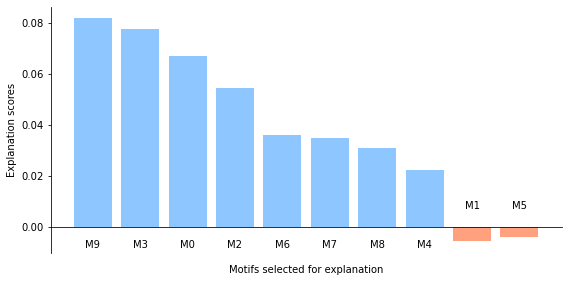

In [18]:
graph_index = 0
q = dict(zip(range(10),shaps10_exact[:,graph_index]))
plot_graphshap_scores(q,'M',is_local=True)
plt.tight_layout()

# Figure 8

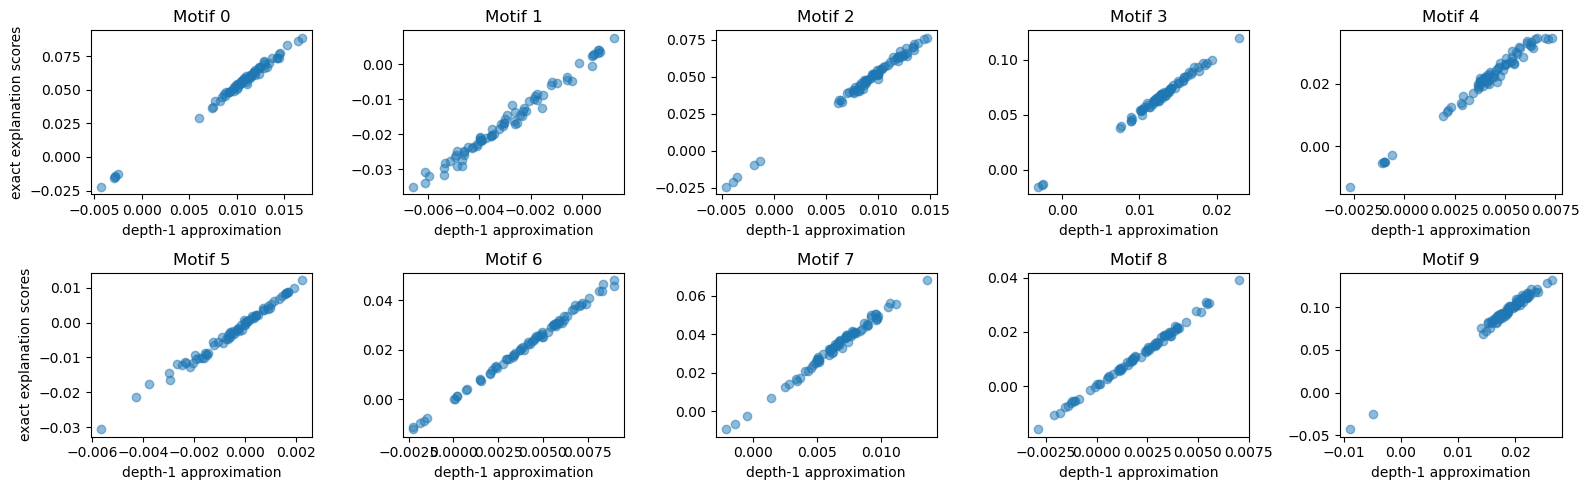

In [19]:
plt.figure(figsize=(16,5))
for m in range(10):
    plt.subplot(2,5,m+1)
    plt.scatter(shaps10_approx[m,:],shaps10_exact[m,:],alpha=.5)
    plt.title('Motif '+str(m))
    plt.xlabel('depth-1 approximation')
plt.subplot(2,5,1)
plt.ylabel('exact explanation scores')
plt.subplot(2,5,6)
plt.ylabel('exact explanation scores')
plt.tight_layout();

In [20]:
redux_lattice100 = get_redux_lattice(gcnv,test_dummy_feats,test_norm_adjs,motifs100)
shaps_tensor100 = get_redux_shaps(redux_lattice100)
shaps100_approx = np.sum(shaps_tensor100,axis=0)
shaps100_global = np.sum(abs(shaps100_approx),axis=1)

# Figure 9

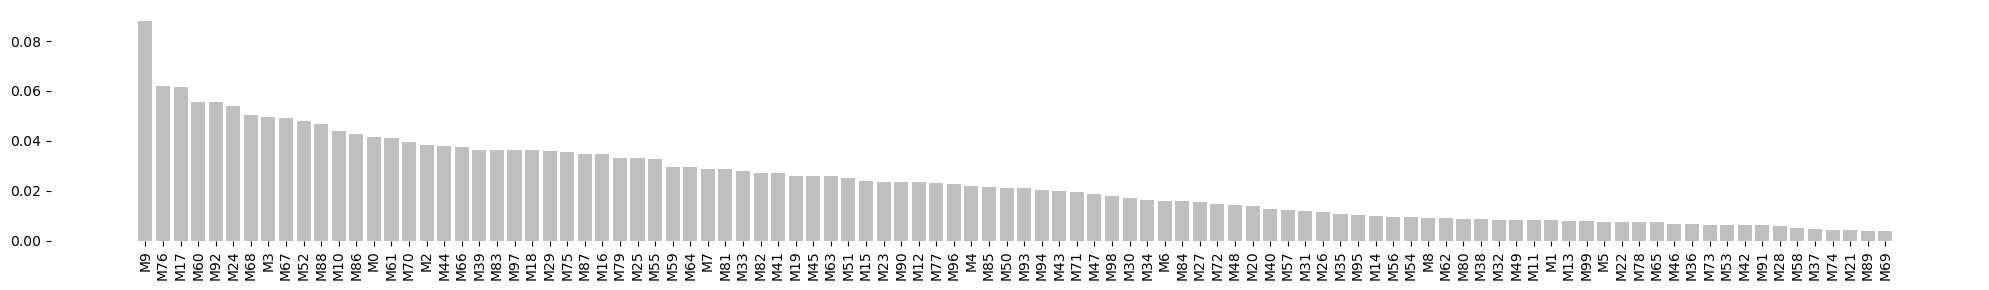

In [21]:
plt.figure(figsize=(20,3))
plt.bar(range(100),sorted(shaps100_global/100)[::-1],color='gray',alpha=.5)
plt.xticks(range(100),['M'+str(i) for i in np.argsort(shaps100_global)[::-1]],rotation=90)
plt.tight_layout()
plt.box(False)
top_motifs = np.argsort(shaps100_global)[::-1][:5]

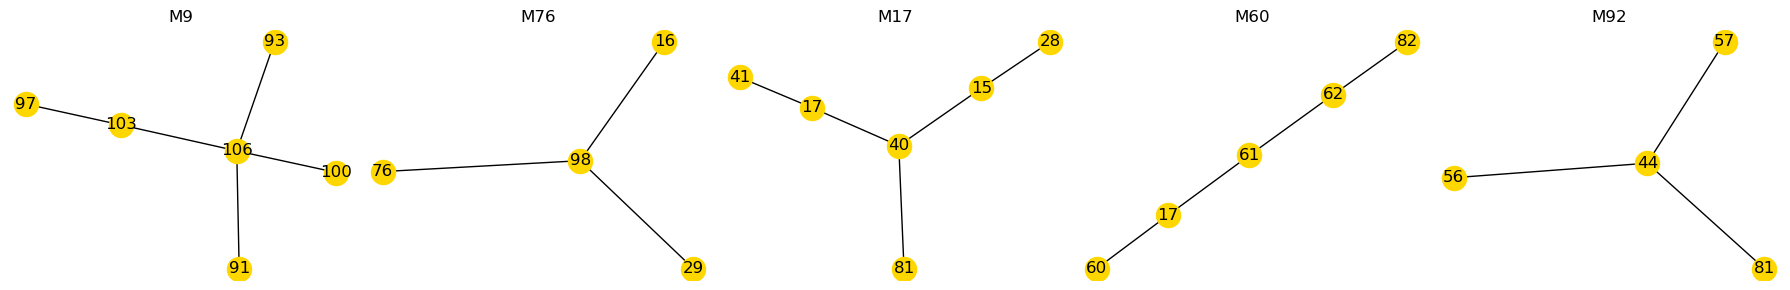

In [22]:
plt.figure(figsize=(18,3))
for indx in range(5):
    plt.subplot(1,5,indx+1)
    plt.box(False)
    plt.xticks([])
    plt.yticks([])
    M_ind = top_motifs[indx]
    nx.draw_networkx(motifs100[M_ind],node_color='gold')
    plt.title('M'+str(M_ind))
plt.tight_layout()

In [23]:
def brainplot_motif(motif,brain_coord):
    adj = np.zeros((116,116))
    for a,b in motif.edges:
        adj[a,b] = 1
        adj[b,a] = 1
    plot_connectome(adj,brain_coord,display_mode='lyrz',node_kwargs={'alpha':.25},
            node_size = 10, edge_kwargs={'linewidth':2,'color':'b'});

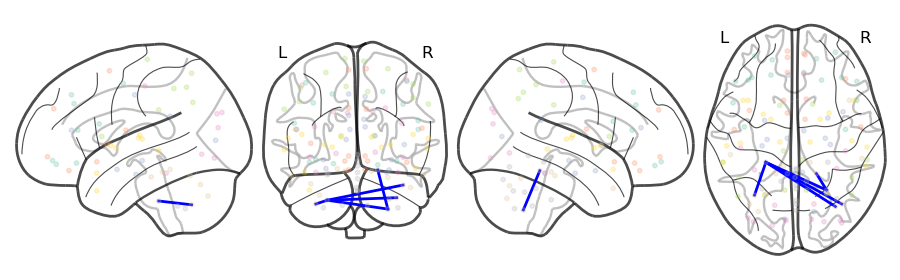

In [24]:
graph_index = top_motifs[0]
brainplot_motif(motifs100[graph_index],brain_coord.values[:,-3:])